# Custom Object Detection  

## 0. Necessary Imports

In [1]:
import torch
print(torch.cuda.is_available())

True


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

## 1. DATASET
I've chosen the **Infinity Stones** from the Marvel Universe as objects to be detected.

### 1.1. Load the objects

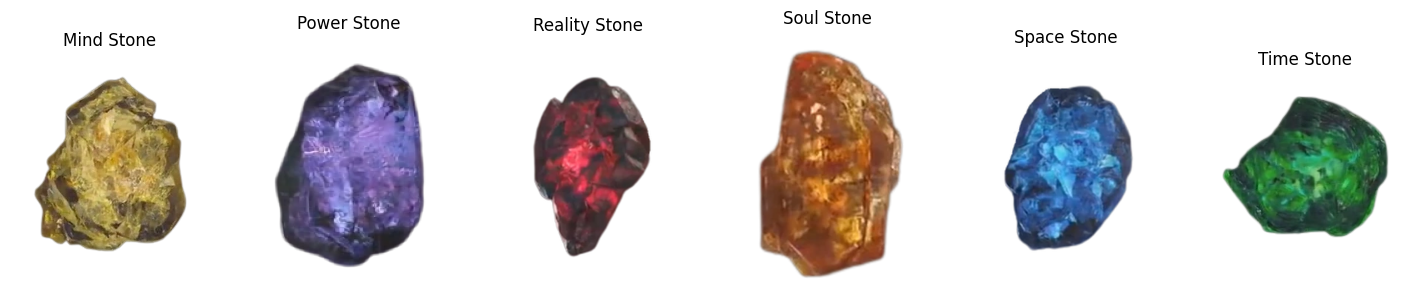

In [3]:
obj_dir = '/kaggle/input/cnn-infinity-stones'

fig, axs = plt.subplots(1, 6, figsize=(18, 4))
axs[0].imshow(plt.imread(f'{obj_dir}/mind_stone.webp'))
axs[0].set_title('Mind Stone')
axs[0].axis('off')

axs[1].imshow(plt.imread(f'{obj_dir}/power_stone.webp'))
axs[1].set_title('Power Stone')
axs[1].axis('off')

axs[2].imshow(plt.imread(f'{obj_dir}/reality_stone.webp'))
axs[2].set_title('Reality Stone')
axs[2].axis('off')

axs[3].imshow(plt.imread(f'{obj_dir}/soul_stone.webp'))
axs[3].set_title('Soul Stone')
axs[3].axis('off')

axs[4].imshow(plt.imread(f'{obj_dir}/space_stone.webp'))
axs[4].set_title('Space Stone')
axs[4].axis('off')

axs[5].imshow(plt.imread(f'{obj_dir}/time_stone.webp'))
axs[5].set_title('Time Stone')
axs[5].axis('off')

plt.show()

### 1.2. Load backgrounds

To train a custom object detection model, a dataset is needed and for this purpose a synthetic dataset will be created by:

- **Inserting an object (each stone) in a random position** on a background image.

**Therefore, an important step is to collect a few background images from different locations** This will be done using **icrawler** to automate the image collection process and using keywords associated with locations from the Marvel Universe.

In [4]:
!mkdir -p /kaggle/working/background

In [5]:
bg_dir = "/kaggle/working/background"

In [6]:
!pip install icrawler

In [7]:
from icrawler.builtin import GoogleImageCrawler

google_crawler = GoogleImageCrawler(
    parser_threads=2,
    downloader_threads=4,
    storage={'root_dir': bg_dir}
)

for keyword in ['Avengers Tower', 'Sanctum Sanctorum background',  'Kamar-Taj temple', 'S.H.I.E.L.D. Helicarrier', 'Asgard background','Vormir background', 'Knowhere', 'Sakaar background', 'futuristic lab interior', 'science exhibition room', 'clean sci-fi control room',
    'abandoned cave interior', 'meteor crater in desert', 'old mystical library', 'messy desk with artifacts']:
    google_crawler.crawl(
        keyword=keyword, max_num=10, file_idx_offset='auto', min_size=(800, 800))

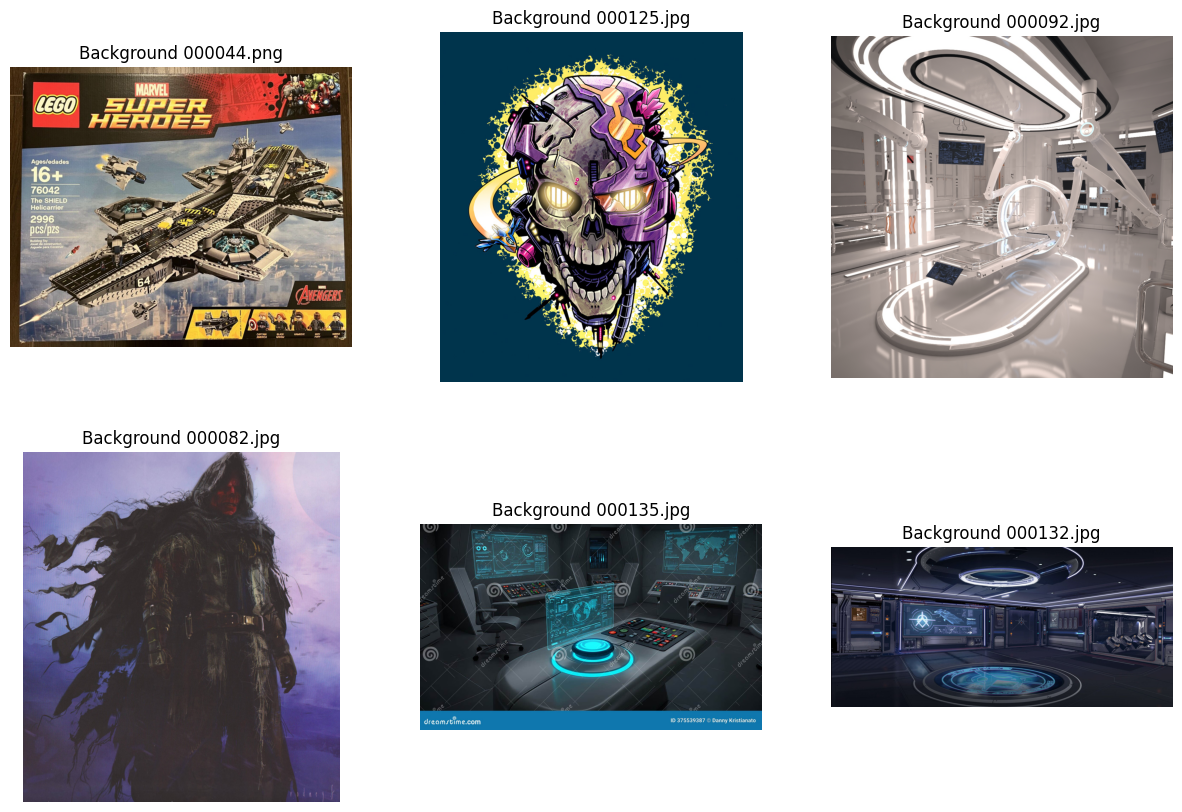

In [9]:
import random as rd

# Show some of the images, to confirm that they were successfully crawled
def display_sample_images(dir):
    img_files = [f for f in os.listdir(bg_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    sel_img = rd.sample(img_files, min(6, len(img_files)))
    cols = 3 
    rows = (5 // cols) + (5 % cols > 0)
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = axes.flatten()

    for ax, img_file in zip(axes, sel_img):
        img_path = os.path.join(dir, img_file)
        img = plt.imread(img_path)
        ax.imshow(img)
        ax.set_title('Background ' + f'{img_file}')
        ax.axis('off')

display_sample_images(bg_dir)

### 1.3. Create dataset

### Dataset Creation

This will be done by:
1. **Randomly selecting background images** from the collection.
2. **Inserting a single object** into each background image at a **random location**.
3. **Recording the object's coordinates** and creating a corresponding bounding box (in the YOLO format).
6. **Wrapping the dataset creation** in a **PyTorch Dataset class** for easier data handling and model training.
7. **Splitting the dataset** into training, validation, and test sets for model evaluation.

In [11]:
from PIL import Image, ImageDraw

In [12]:
def createDataset(root_dir, dataset_name, split, img_size, num_images):
    dt_dir = os.path.join(root_dir, dataset_name, split)
    img_dir = os.path.join(dt_dir, 'images')
    lbl_dir = os.path.join(dt_dir, 'labels')
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(lbl_dir, exist_ok=True)
    bg_dir = "/kaggle/working/background"

    bg_imgs = [os.path.join(bg_dir, bg_img) for bg_img in os.listdir(bg_dir) if bg_img.endswith(('.png', '.jpg', '.jpeg'))]

    obj_imgs = [
        {'name': 'mind stone', 'filename': f'{obj_dir}/mind_stone.webp', 'size': (120, 120), 'class_id': 0},
        {'name': 'power stone', 'filename': f'{obj_dir}/power_stone.webp', 'size': (120, 120), 'class_id': 1},
        {'name': 'reality stone', 'filename': f'{obj_dir}/reality_stone.webp', 'size': (120, 120), 'class_id': 2},
        {'name': 'soul stone', 'filename': f'{obj_dir}/soul_stone.webp', 'size': (120, 120), 'class_id': 3},
        {'name': 'space stone', 'filename': f'{obj_dir}/space_stone.webp', 'size': (120, 120), 'class_id': 4},
        {'name': 'time stone', 'filename': f'{obj_dir}/time_stone.webp', 'size': (120, 120), 'class_id': 5}]
    

    for i in range(num_images):
            bg_dir = rd.choice(bg_imgs)
            bg_img = Image.open(bg_dir).resize(img_size)
            if bg_img.mode != 'RGB':
               bg_img = bg_img.convert('RGB')

            #randomly selecting an obj image to paste on a bg
            obj = rd.choice(obj_imgs)
            obj_name = obj['name']
            obj_filename = obj['filename']
            obj_size = obj['size']
            class_id = obj['class_id']

            obj_img = Image.open(obj_filename).resize(obj_size)

            #choosing a random location for pasting the obj_img
            max_x = img_size[0] - obj_size[0]
            max_y = img_size[1] - obj_size[1]
            x = rd.randint(0, max_x)
            y = rd.randint(0, max_y)

            bg_img.paste(obj_img, (x, y), obj_img) 

            x_center = (x + obj_size[0] / 2) / img_size[0] 
            y_center = (y + obj_size[1] / 2) / img_size[1]
            width = obj_size[0] / img_size[0]
            height = obj_size[1] / img_size[1]

            img_filename = f'{i:05d}.jpg'
            lbl_filename = f'{i:05d}.txt'

            bg_img.save(os.path.join(img_dir, img_filename))

            # Saving label file with YOLO format bounding box coordinates
            with open(os.path.join(lbl_dir, lbl_filename ), 'w') as f:
                f.write(f'{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}')

In [13]:
dt_dir = "/kaggle/working"

In [14]:
createDataset(dt_dir, 'dataset', split='train', img_size=(640,640), num_images=5000)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [15]:
createDataset(dt_dir, 'dataset', split='val', img_size=(640,640), num_images=1000)

In [16]:
createDataset(dt_dir, 'dataset', split='test', img_size=(640,640), num_images=200)

In [17]:
class ObjectDetectionDataset(Dataset):
    def __init__(self, root_dir, split='train', num_classes=6, transform=None):
        self.root_dir = root_dir
        self.split_dir = os.path.join(root_dir, split)
        self.image_dir = os.path.join(self.split_dir, 'images')
        self.label_dir = os.path.join(self.split_dir, 'labels')
        self.image_filenames = sorted(os.listdir(self.image_dir))
        self.transform = transform
        self.num_classes = num_classes

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        width, height = image.size

        label_name = img_name.replace('.jpg', '.txt')
        label_path = os.path.join(self.label_dir, label_name)
        with open(label_path, 'r') as f:
            label_info = f.readline().strip().split()
            category = int(label_info[0])   #we save the params in the label.txt in the following order: categor, cen_x, cen_y, width, height;
            bbox = list(map(float, label_info[1:]))
            

        if self.transform:
          image = self.transform(image)  

        return image, torch.tensor(category), torch.tensor(bbox)

In [18]:
root_dir = "/kaggle/working/dataset"
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

train_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.3, hue=0.1),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

train_dataset = ObjectDetectionDataset(root_dir, split='train', transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)

val_dataset = ObjectDetectionDataset(root_dir, split='val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)


test_dataset = ObjectDetectionDataset(root_dir, split='test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

In [19]:
def visualize_dataset(dataset, num_images=6, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    indices = np.random.choice(len(dataset), size=num_images, replace=False)

    num_rows = int(np.sqrt(num_images))
    num_cols = int(np.ceil(num_images / num_rows))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))
    fig.suptitle('Some Dataset Images with Bounding Boxes', fontsize=16)

    if num_images == 1:
        axes = np.array([axes])

    for i, idx in enumerate(indices):
        image, category, bbox = dataset[idx]

        # Undo normalization (denormalize)
        image = image.clone()  # avoid modifying original tensor
        for t, m, s in zip(image, mean, std):
            t.mul_(s).add_(m)
        image = torch.clamp(image, 0, 1)

        image = image.permute(1, 2, 0).numpy()  # (H, W, C)

        ax = axes[i // num_cols, i % num_cols]
        ax.imshow(image)
        ax.axis('off')

        x_center, y_center, width, height = bbox

        x1 = x_center - width / 2
        y1 = y_center - height / 2
        x2 = x_center + width / 2
        y2 = y_center + height / 2

        x1_pixel = x1 * image.shape[1]
        y1_pixel = y1 * image.shape[0]
        x2_pixel = x2 * image.shape[1]
        y2_pixel = y2 * image.shape[0]

        rect = plt.Rectangle((x1_pixel, y1_pixel), x2_pixel - x1_pixel, y2_pixel - y1_pixel,
                             linewidth=2, edgecolor='yellow', facecolor='none')
        ax.add_patch(rect)

        ax.set_title(f'Category: {int(category)}')

    plt.tight_layout(pad=1.0, h_pad=0.5, w_pad=0.5)
    plt.show()


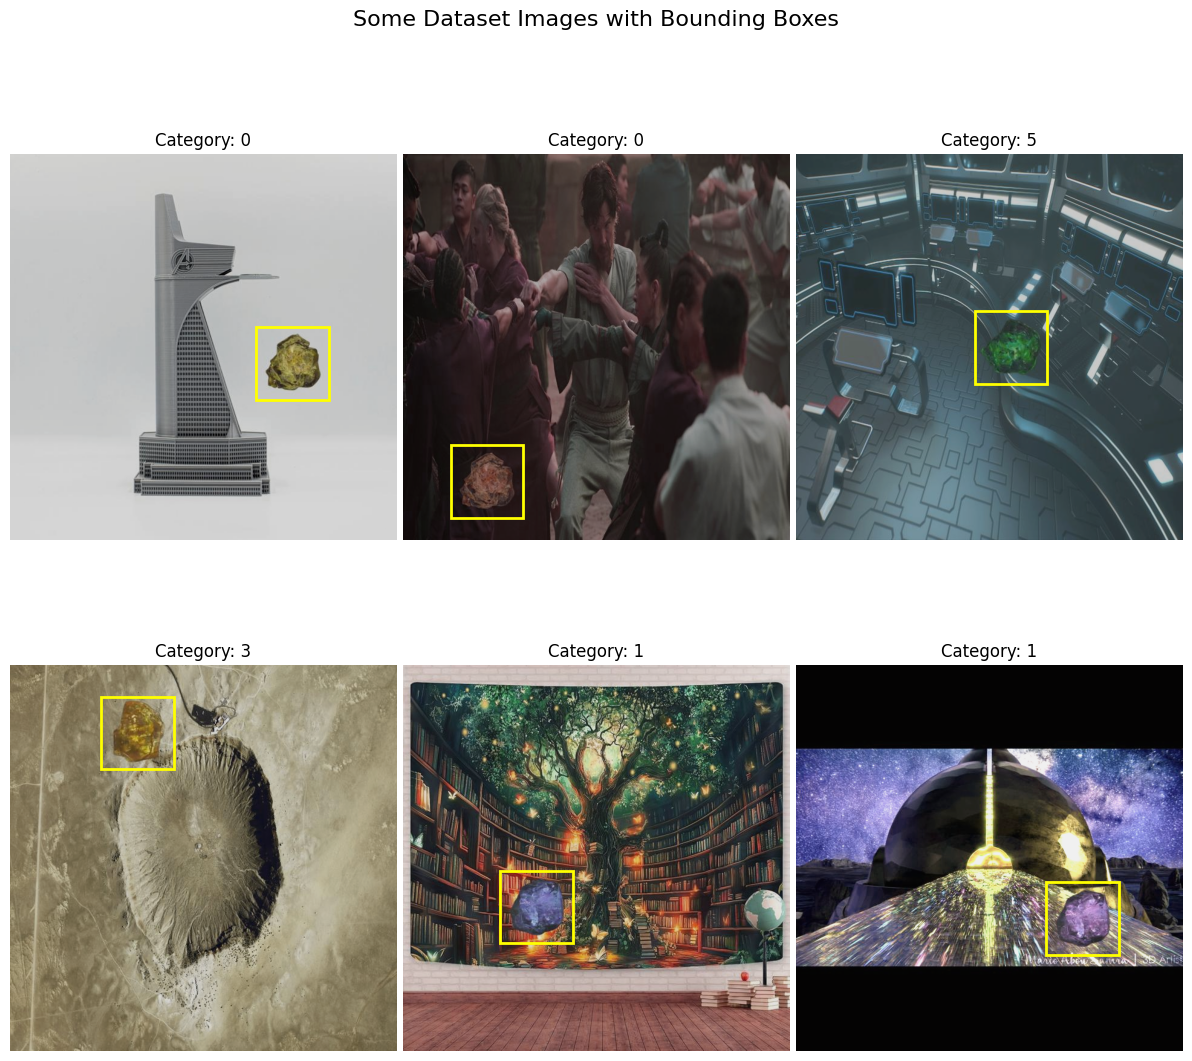

In [20]:
visualize_dataset(train_dataset, num_images=6)

### 2. Model Training

### 2.1. Custom Object Detection model

### Custom Convolutional Neural Network (CNN) Architecture

For this task a CNN-based architecture that includes a **backbone for feature extraction** and two output branches:

- One for **class probabilities** (with output size equal to the number of object classes).
- Another for **bounding box regression** (with size 4 for the box coordinates: x, y, w, h, or in YOLO format).

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [22]:
class CustomModel(nn.Module):
    def __init__(self, num_classes=6):
        super(CustomModel, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            dummy = torch.zeros(1, 3, 640, 640)
            dummy = self.pool(F.relu(self.conv1(dummy)))
            dummy = self.pool(F.relu(self.conv2(dummy)))
            dummy = self.pool(F.relu(self.conv3(dummy)))
            dummy = self.pool(F.relu(self.conv4(dummy)))
            self.fc1_input_size = dummy.numel()

        self.fc1 = nn.Linear(self.fc1_input_size, 1024)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(1024, 512)
        self.classifier = nn.Linear(512, num_classes)
        self.bbox_regressor = nn.Linear(512, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        x = x.view(-1, self.fc1_input_size)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))

        class_probs = self.classifier(x)
        bbox_coords = torch.sigmoid(self.bbox_regressor(x))

        return class_probs, bbox_coords

In [23]:
dummy_image = torch.randn(1, 3, 640, 640).to(device)
num_classes = 6

model = CustomModel(num_classes).to(device)
cls_output, bbox_output = model(dummy_image)

print("Class Output Shape:", cls_output.shape)
print("Bounding Box Output Shape:", bbox_output.shape)

Class Output Shape: torch.Size([1, 6])
Bounding Box Output Shape: torch.Size([1, 4])


### 2.2. Train the Model

In this section key components like the **optimizer**, **loss function**, **number of epochs**, and **regularization techniques** will be tuned optimizing both **classification loss** and **bounding box regression loss**.

Signs of **overfitting** or **underfitting** will be monitored by tracking how the loss evolves across epochs. 


<a href="https://ibb.co/bzmMxJY"><img src="https://i.ibb.co/t8KTSXn/download.png" alt="download" border="0"></a>

In [24]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay= 1e-4)
class_loss_fn = nn.CrossEntropyLoss()
bbox_loss_fn = nn.SmoothL1Loss()

In [25]:
def train_model(model, train_loader, val_loader, optimizer, class_loss_fn, bbox_loss_fn, num_epochs=15, save_path='best_model.pth'):
    train_cls_losses = []
    train_bbox_losses = []
    val_cls_losses = []
    val_bbox_losses = []

    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss_cls = 0.0
        train_loss_bbox = 0.0

        for images, categories, bboxes in train_loader:
            images, categories, bboxes = images.to(device), categories.to(device), bboxes.to(device)

            optimizer.zero_grad()
            class_logits, bbox_coords = model(images)

            loss_cls = class_loss_fn(class_logits, categories)
            loss_bbox = bbox_loss_fn(bbox_coords, bboxes)

            total_loss = loss_cls + 100.0 * loss_bbox
            total_loss.backward()
            optimizer.step()

            train_loss_cls += loss_cls.item()
            train_loss_bbox += loss_bbox.item()

        train_loss_cls /= len(train_loader)
        train_loss_bbox /= len(train_loader)

        train_cls_losses.append(train_loss_cls)
        train_bbox_losses.append(train_loss_bbox)

        model.eval()
        val_loss_cls = 0.0
        val_loss_bbox = 0.0

        with torch.no_grad():
            for images, categories, bboxes in val_loader:
                images, categories, bboxes = images.to(device), categories.to(device), bboxes.to(device)

                class_logits, bbox_coords = model(images)

                loss_cls = class_loss_fn(class_logits, categories)
                loss_bbox = bbox_loss_fn(bbox_coords, bboxes)

                val_loss_cls += loss_cls.item()
                val_loss_bbox += loss_bbox.item()

        val_loss_cls /= len(val_loader)
        val_loss_bbox /= len(val_loader)

        val_cls_losses.append(val_loss_cls)
        val_bbox_losses.append(val_loss_bbox)

        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss (Cls: {train_loss_cls:.4f}, BBox: {train_loss_bbox:.4f}), '
              f'Val Loss (Cls: {val_loss_cls:.4f}, BBox: {val_loss_bbox:.4f})')

        # Save model every epoch (or you can customize condition)
        current_val_loss = val_loss_cls + 100.0 * val_loss_bbox
        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss
            torch.save(model.state_dict(), save_path)
            print(f"Best model saved at epoch {epoch + 1} with validation loss: {best_val_loss:.4f}")

    return train_cls_losses, train_bbox_losses, val_cls_losses, val_bbox_losses

In [26]:
def plot_losses(train_cls_losses, train_bbox_losses, val_cls_losses, val_bbox_losses):
    plt.figure(figsize=(12, 5))

    #classification losses
    plt.subplot(1, 2, 1)
    plt.plot(train_cls_losses, label='Training Classification Loss', color='blue')
    plt.plot(val_cls_losses, label='Validation Classification Loss', color='orange')
    plt.title('Classification Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    #bbox losses
    plt.subplot(1, 2, 2)
    plt.plot(train_bbox_losses, label='Training Bounding Box Loss', color='green')
    plt.plot(val_bbox_losses, label='Validation Bounding Box Loss', color='red')
    plt.title('Bounding Box Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

In [27]:
train_cls_losses, train_bbox_losses, val_cls_losses, val_bbox_losses = train_model(model, train_loader, val_loader, optimizer, class_loss_fn, bbox_loss_fn, num_epochs=15)

Epoch [1/15], Train Loss (Cls: 1.7986, BBox: 0.0144), Val Loss (Cls: 1.7957, BBox: 0.0137)
Best model saved at epoch 1 with validation loss: 3.1699
Epoch [2/15], Train Loss (Cls: 1.7700, BBox: 0.0123), Val Loss (Cls: 1.6507, BBox: 0.0098)
Best model saved at epoch 2 with validation loss: 2.6319
Epoch [3/15], Train Loss (Cls: 1.5788, BBox: 0.0101), Val Loss (Cls: 1.2557, BBox: 0.0083)
Best model saved at epoch 3 with validation loss: 2.0819
Epoch [4/15], Train Loss (Cls: 1.3183, BBox: 0.0076), Val Loss (Cls: 1.0317, BBox: 0.0029)
Best model saved at epoch 4 with validation loss: 1.3180
Epoch [5/15], Train Loss (Cls: 1.0654, BBox: 0.0039), Val Loss (Cls: 0.7591, BBox: 0.0017)
Best model saved at epoch 5 with validation loss: 0.9325
Epoch [6/15], Train Loss (Cls: 0.7563, BBox: 0.0023), Val Loss (Cls: 0.4213, BBox: 0.0016)
Best model saved at epoch 6 with validation loss: 0.5858
Epoch [7/15], Train Loss (Cls: 0.4561, BBox: 0.0017), Val Loss (Cls: 0.2021, BBox: 0.0014)
Best model saved at e

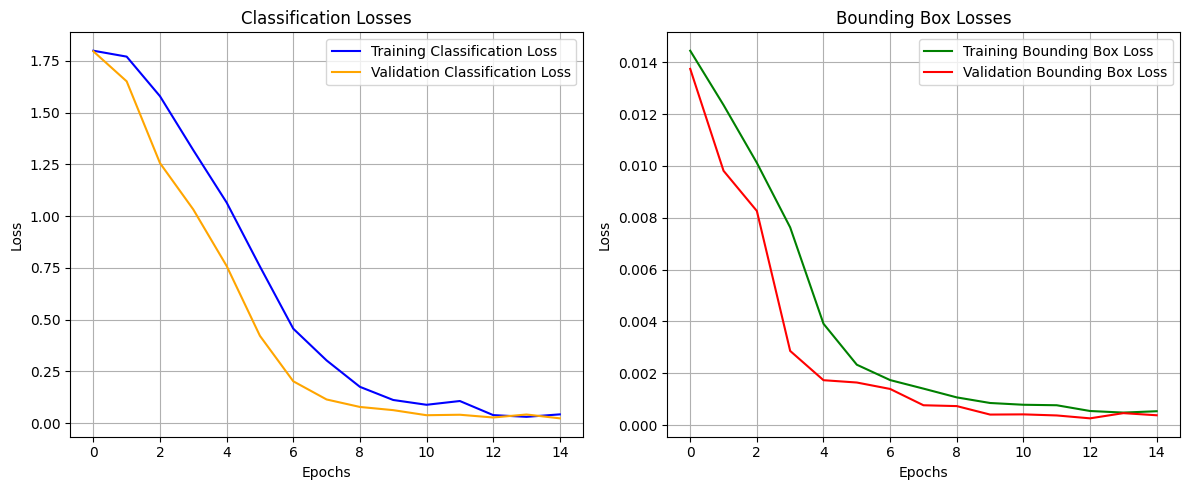

In [28]:
plot_losses(train_cls_losses, train_bbox_losses, val_cls_losses, val_bbox_losses)

### 2.3. Evaulate and do inference with the trained custom model

To evaluate the performance of the trained object detection model these metrics will be used:

- **Precision**: The proportion of correctly predicted positive instances (objects detected) out of all instances classified as positive.
- **Recall**: The proportion of correctly predicted positive instances out of all actual positive instances (objects present in the image).
- **IoU (Intersection over Union)**: Measures the overlap between the predicted bounding box and the ground truth bounding box.
- **mAP (mean Average Precision)**: This is one of the most common evaluation metrics for object detection. It averages precision at different recall thresholds across all object classes.

In [29]:
state_dict = torch.load('best_model.pth', weights_only=True)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [31]:
def calculate_precision(model, test_loader, device):
    model.eval()
    true_positive = 0
    false_positive = 0

    with torch.no_grad():
        for images, labels, _ in test_loader:
            images, labels = images.to(device), labels.to(device)

            #Get predictions
            class_probs, _ = model(images)
            predicted_labels = torch.argmax(class_probs, dim=1)

            class_labels = labels


            true_positive += (predicted_labels == class_labels).sum().item()
            false_positive += (predicted_labels != class_labels).sum().item()

    #Calculate precision
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0.0
    return precision

In [32]:
def calculate_mAP(model, test_loader, device):
    num_classes = 6
    class_ap = [0.0] * num_classes
    num_samples = [0] * num_classes

    with torch.no_grad():
        for images, labels, _ in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            class_preds, _ = model(images)

            if labels.ndim > 1:
                class_labels = torch.argmax(labels, dim=1)
            else:
                class_labels = labels

            for class_idx in range(num_classes):

                class_mask = class_labels == class_idx
                class_preds_filtered = class_preds[class_mask]
                class_labels_filtered = class_labels[class_mask]

                #Skip if there are no ground truth labels for this class in the batch
                if class_labels_filtered.numel() == 0:
                    continue

                # Sort predictions by the confidence score for this class
                confidences = class_preds_filtered[:, class_idx]
                sorted_indices = torch.argsort(confidences, descending=True)
                sorted_labels = class_labels_filtered[sorted_indices] == class_idx  # Binary labels

                # Calculate True Positives (TP) and False Positives (FP)
                tp = torch.cumsum(sorted_labels, dim=0)
                fp = torch.cumsum(~sorted_labels, dim=0)

                # Calculate recall and precision
                recall = tp.float() / tp[-1].float()  # Normalized recall for this class
                precision = tp.float() / (tp + fp).float()

                # Calculate AP as the area under the precision-recall curve
                ap = torch.sum(precision * recall) / len(tp)  # Integrate over the precision-recall curve
                class_ap[class_idx] += ap.item()
                num_samples[class_idx] += 1

    # Calculate mean Average Precision (mAP)
    mAP = sum(class_ap[class_idx] / num_samples[class_idx] for class_idx in range(num_classes) if num_samples[class_idx] > 0) / num_classes
    return mAP


In [33]:
def calculate_recall(model, test_loader, device):
    num_classes = 6
    class_recall = [0.0] * num_classes  #To store recall for each class
    num_samples = [0] * num_classes  #To count true positives for each class

    with torch.no_grad():
        for images, labels, _ in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            class_preds, _ = model(images)  #Get class predictions

            #Convert one-hot encoded labels to class indices if needed
            if labels.ndim > 1:
                class_labels = torch.argmax(labels, dim=1)
            else:
                class_labels = labels  # Already class indices

            for class_idx in range(num_classes):
                # Mask for current class to separate out relevant predictions and labels
                class_mask = class_labels == class_idx
                class_preds_filtered = class_preds[class_mask]
                class_labels_filtered = class_labels[class_mask]

                if class_labels_filtered.numel() == 0:
                    continue

                true_positives = torch.sum(torch.argmax(class_preds_filtered, dim=1) == class_idx).item()

                class_recall[class_idx] += true_positives
                num_samples[class_idx] += len(class_labels_filtered)

    #Calculate recall for each class
    class_recall = [class_recall[class_idx] / num_samples[class_idx] if num_samples[class_idx] > 0 else 0.0 for class_idx in range(num_classes)]

    return class_recall

In [34]:
def calculate_iou(pred_bbox, true_bbox):
    # pred_bbox and true_bbox should be in the format [x1, y1, x2, y2]
    x1_inter = max(pred_bbox[0], true_bbox[0])
    y1_inter = max(pred_bbox[1], true_bbox[1])
    x2_inter = min(pred_bbox[2], true_bbox[2])
    y2_inter = min(pred_bbox[3], true_bbox[3])

    # Compute the area of intersection
    inter_area = max(0, x2_inter - x1_inter) * max(0, y2_inter - y1_inter)

    # Compute the area of both the predicted and ground truth boxes
    pred_area = (pred_bbox[2] - pred_bbox[0]) * (pred_bbox[3] - pred_bbox[1])
    true_area = (true_bbox[2] - true_bbox[0]) * (true_bbox[3] - true_bbox[1])

    # Compute IoU
    union_area = pred_area + true_area - inter_area
    iou = inter_area / union_area if union_area > 0 else 0

    return iou

def calculate_average_iou(pred_bboxes, true_bboxes):
    total_iou = 0
    num_boxes = len(true_bboxes)

    for pred_bbox, true_bbox in zip(pred_bboxes, true_bboxes):
        total_iou += calculate_iou(pred_bbox.cpu().numpy(), true_bbox.cpu().numpy())  # Ensure they are on CPU for NumPy

    return total_iou / num_boxes if num_boxes > 0 else 0.0


In [35]:
precision = calculate_precision(model, test_loader, device)
print(f"Precision: {precision:.4f}")

Precision: 0.9950


In [36]:
mAP = calculate_mAP(model, test_loader, device)
print(f"mAP: {mAP:.4f}")

mAP: 0.7307


In [37]:
recall_values = calculate_recall(model, test_loader, device)
for class_idx, recall in enumerate(recall_values):
    print(f"Recall for class {class_idx}: {recall:.4f}")

Recall for class 0: 0.9697
Recall for class 1: 1.0000
Recall for class 2: 1.0000
Recall for class 3: 1.0000
Recall for class 4: 1.0000
Recall for class 5: 1.0000


In [38]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def predict_and_visualize(model, image_path, device):
    image = Image.open(image_path).convert('RGB')
    transformed_image = transform(image)
    image_tensor = transformed_image.unsqueeze(0).to(device)

    with torch.no_grad():
        class_probs, bbox_coords = model(image_tensor)

    predicted_class = torch.argmax(class_probs, dim=1).cpu().item()
    probabilities = torch.softmax(class_probs, dim=1)
    predicted_score = probabilities.max(dim=1)[0].cpu().item()
    predicted_bbox = bbox_coords.cpu().numpy()[0]  # normalized bbox: [cx, cy, w, h]

    _, img_h, img_w = transformed_image.shape  # (width, height)

    cx, cy, w, h = predicted_bbox

    # Convert center_x, center_y, width, height (normalized) to top-left corner and width/height in pixels
    x1 = (cx - w / 2) * img_w
    y1 = (cy - h / 2) * img_h
    box_width = w * img_w
    box_height = h * img_h

    # Plot image and predicted bounding box
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    ax = plt.gca()

    rect = patches.Rectangle((x1, y1), box_width, box_height,
                             linewidth=2, edgecolor='green', facecolor='none')
    ax.add_patch(rect)

    plt.text(x1, y1, f'Class: {predicted_class}, Score: {predicted_score:.2f}\nBBox: [{cx:.2f}, {cy:.2f}, {w:.2f}, {h:.2f}]',
             color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

    plt.axis('off')
    plt.title('Prediction Result')
    plt.show()


In [39]:
import matplotlib.patches as patches

def predict_and_visualize(model, image_path, device):
    image = Image.open(image_path).convert('RGB')
    orig_w, orig_h = image.size

    # Transform image for model input (e.g., resize to 640x640 + normalization)
    transformed_image = transform(image)
    image_tensor = transformed_image.unsqueeze(0).to(device)

    with torch.no_grad():
        class_logits, bbox_coords = model(image_tensor)

    probabilities = torch.softmax(class_logits, dim=1).cpu()
    predicted_class = torch.argmax(probabilities, dim=1).item()
    predicted_score = probabilities[0, predicted_class].item()
    predicted_bbox = bbox_coords.cpu().numpy()[0]  # normalized bbox: [cx, cy, w, h]

    cx, cy, w, h = predicted_bbox

    # Convert normalized bbox to original image coordinates
    x1 = (cx - w / 2) * orig_w
    y1 = (cy - h / 2) * orig_h
    box_width = w * orig_w
    box_height = h * orig_h

    # Clip bounding box coordinates to image boundaries
    x1 = max(0, x1)
    y1 = max(0, y1)
    box_width = min(orig_w - x1, box_width)
    box_height = min(orig_h - y1, box_height)

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    ax = plt.gca()

    rect = patches.Rectangle((x1, y1), box_width, box_height,
                             linewidth=2, edgecolor='green', facecolor='none')
    ax.add_patch(rect)

    plt.text(x1, y1, f'Class: {predicted_class}, Score: {predicted_score:.2f}',
             color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

    plt.axis('off')
    plt.title('Prediction Result')
    plt.show()

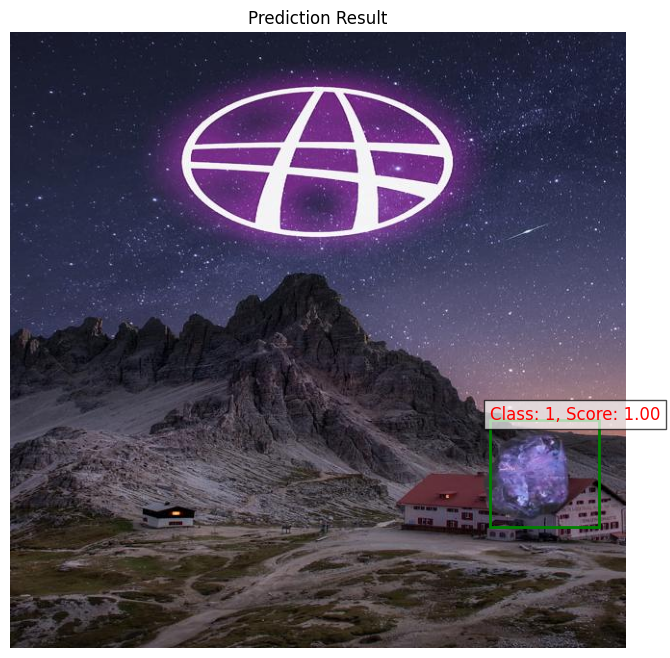

In [64]:
img1 = '/kaggle/working/dataset/test/images/00023.jpg'  # Replace with your image path
predict_and_visualize(model, img1, device)